<a href="https://colab.research.google.com/github/slavyolov/Algorithms/blob/main/RL_Taxi_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taxi case background 🚕

Please read the page for general information about the environment : https://www.gymlibrary.dev/environments/toy_text/taxi/


**Actions and observations**
*   **Action Space** : Discrete(6)
*   **Observation Space** :Discrete(500)


**Rewards**
* -1 per step unless other reward is triggered.
*   +20 delivering passenger.
*   -10 executing “pickup” and “drop-off” actions illegally.







# Setup the environment

In [1]:
!pip install cmake 'gym[atari]' scipy

In [2]:
import gym
import numpy as np
from datetime import datetime
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import argparse
import random
import time
import gym
import sys

is_notebook = 'inline' in matplotlib.get_backend()

if is_notebook:
    from IPython import display

env = gym.make("Taxi-v3").env
env.reset()

print("Display the environment at a random state : ")
print(env.render(mode='ansi'))

Display the environment at a random state : 
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [3]:
demo_env_state = env.s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
print(100 * "=")
print('''
There are 6 discrete deterministic actions:

0: move south
1: move north
2: move east
3: move west
4: pickup passenger
5: drop off passenger
''')

print(100 * "=")
print("Structure of the dictionary : {action: [(probability, nextstate, reward, done)]}")
env.P[demo_env_state]


There are 6 discrete deterministic actions:

0: move south
1: move north
2: move east
3: move west
4: pickup passenger
5: drop off passenger

Structure of the dictionary : {action: [(probability, nextstate, reward, done)]}


{0: [(1.0, 467, -1, False)],
 1: [(1.0, 367, -1, False)],
 2: [(1.0, 487, -1, False)],
 3: [(1.0, 467, -1, False)],
 4: [(1.0, 467, -10, False)],
 5: [(1.0, 467, -10, False)]}

# Brute force approach

- Note : the environment may complete in few timesteps or in thousands.
- Overall there is no learning from previous experience

In [5]:
# Set environment to a random state for illustration purposes
env.s = demo_env_state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1

    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1

# Note : the environment may complete in few timesteps or in thousands.
# Overall there is no learning from previous experience
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1075
Penalties incurred: 352


In [6]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1075
State: 475
Action: 5
Reward: 20


# Reinforcement learning (Q learning)

The Q-Learning Process

1. Initialize the Q-table by all zeros.
2. Start exploring actions: For each state, select any one among all possible actions for the current state (S).
3. Travel to the next state (S') as a result of that action (a).
4. For all possible actions from the state (S') select the one with the highest Q-value.
5. Update Q-table values using the equation.
6. Set the next state as the current state.
7. If goal state is reached, then end and repeat the process.

In [7]:
env.reset() # reset environment to a new, random state
print(env.render(mode='ansi'))

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Action Space Discrete(6)
State Space Discrete(500)


In [8]:
# Define Q table
q_table = np.zeros([env.observation_space.n, env.action_space.n])
print(q_table)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


### Train RL model

In [9]:
# Plot functions to vizualise the training process

def plot_durations(episode_durations: list,
                   reward_in_episode: list,
                   epsilon_vec: list,
                   max_steps_per_episode: int = 100) -> None:
    '''Plot graphs containing Epsilon, Rewards, and Steps per episode over time'''
    lines = []
    fig = plt.figure(1, figsize=(15, 7))
    plt.clf()
    ax1 = fig.add_subplot(111)

    plt.title(f'Training...')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Duration & Rewards')
    ax1.set_ylim(-2 * max_steps_per_episode, max_steps_per_episode + 10)
    ax1.plot(episode_durations, color="C1", alpha=0.2)
    ax1.plot(reward_in_episode, color="C2", alpha=0.2)
    mean_steps = moving_average(episode_durations, periods=5)
    mean_reward = moving_average(reward_in_episode, periods=5)
    lines.append(ax1.plot(mean_steps, label="steps", color="C1")[0])
    lines.append(ax1.plot(mean_reward, label="rewards", color="C2")[0])

    ax2 = ax1.twinx()
    ax2.set_ylabel('Epsilon')
    lines.append(ax2.plot(epsilon_vec, label="epsilon", color="C3")[0])
    labs = [l.get_label() for l in lines]
    ax1.legend(lines, labs, loc=3)

    if is_notebook:
        display.clear_output(wait=True)
    else:
        plt.show()
    plt.pause(0.001)

    return

def moving_average(x: list, periods: int = 5) -> list:
    if len(x) < periods:

        return x

    cumsum = np.cumsum(np.insert(x, 0, 0))
    res = (cumsum[periods:] - cumsum[:-periods]) / periods

    return np.hstack([x[:periods - 1], res])

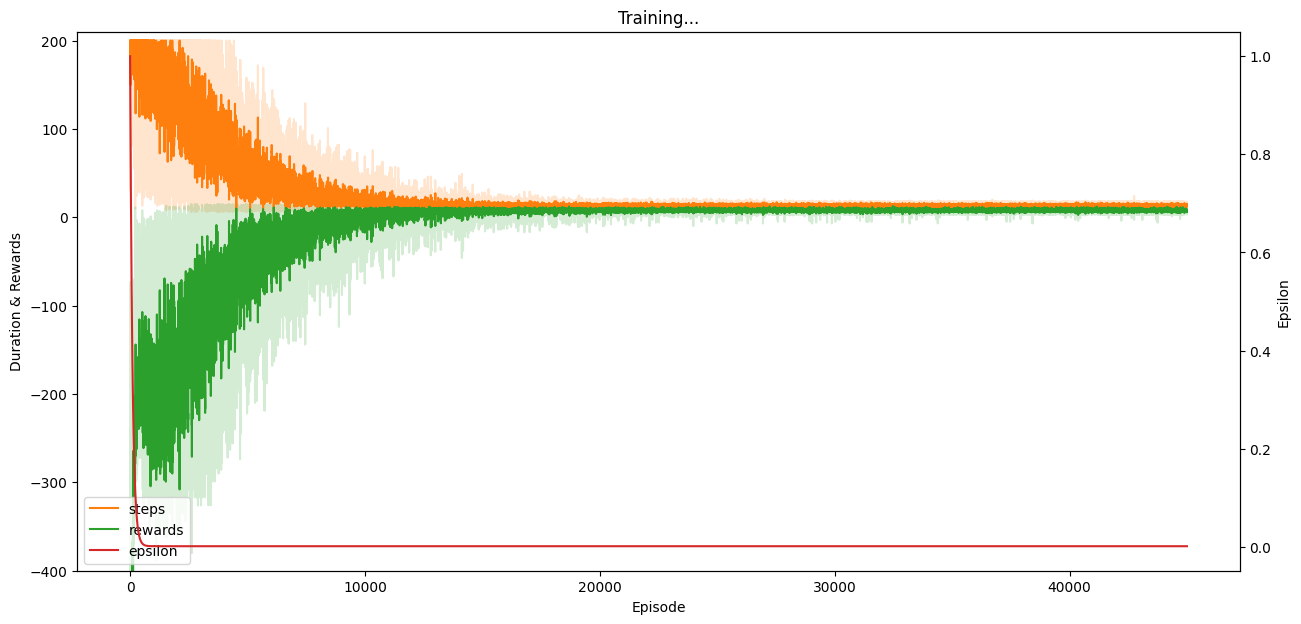


2023-06-28 23:14:13.867037 - Training Ended
Mean Reward: -13.259088888888888
Time to train: 
    - 74.2s
    - 1.24min
    - 0.02h
Mean Time Per Episode: 0.001649
Found 101 empty lines in the Q Table - 20%.


(74.2, -13.259088888888888)

<Figure size 640x480 with 0 Axes>

In [10]:
from datetime import datetime

# Training the RL agent :
def train(env=gym.make("Taxi-v3"),
          episodes: int = 25000,
          lr: float = 0.01,
          gamma: float = 0.99,
          epsilon: float = 1,
          max_epsilon: float = 1,
          min_epsilon: float = 0.001,
          epsilon_decay: float = 0.01,
          show_empty: bool = True,
          path_table: str = "qtable",
          path_graph: str = "QLearning_graph.png") -> tuple[float, int]:
    """
    Train RL agent using Q Learning

    Artefacts:
        Qtable - updated Q table
        QLearning_graph - graph that displayes the elarning process

    Returns:

    """

    # define the q table
    q_table = np.zeros([env.observation_space.n, env.action_space.n])

    start_date = datetime.now()
    start_time = time.time()
    total_reward = []
    steps_per_episode = []
    epsilon_vec = []

    print("{} - Starting Training...\n".format(start_date))
    start_episode = time.time()
    for e in range(episodes):
        state = env.reset()

        done = False
        total_reward.append(0)
        steps_per_episode.append(0)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(
            -epsilon_decay * e)
        epsilon_vec.append(epsilon)
        # Display random episodes
        display_episode = random.uniform(0, 1) < 0.001

        # Loop as long as the game is not over, i.e. done is not True
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore the action space
            else:
                action = np.argmax(q_table[state])  # Exploit learned values

            # Apply the action and see what happens
            next_state, reward, done, _ = env.step(action)
            total_reward[e] += reward
            steps_per_episode[e] += 1

            current_value = q_table[
                state, action]  # current Q-value for the state/action couple
            next_max = np.max(q_table[next_state])  # next best Q-value

            # Compute the new Q-value with the Bellman equation
            q_table[state, action] = (1 - lr) * current_value + lr * (
                reward + gamma * next_max)
            state = next_state
            if display_episode:
                env.render(mode='ansi')

        if e % int(episodes / 100) == 0:
            episode_time = (time.time() - start_episode)
            print(
                "[EPISODE {}/{}] - Mean reward for last {} Episodes: {} in {} steps - Mean Time Per Episode: {}"
                .format(e, episodes, int(episodes / 100),
                        np.mean(total_reward[-int(episodes / 100):]),
                        np.mean(steps_per_episode[-int(episodes / 100):]),
                        np.round(episode_time / e, 6) if e != 0 else 0))

    plot_durations(steps_per_episode,
                   total_reward,
                   epsilon_vec,
                   max_steps_per_episode=200)
    end_date = datetime.now()
    execution_time = (time.time() - start_time)

    print()
    print("{} - Training Ended".format(end_date))
    print("Mean Reward: {}".format(np.mean(total_reward)))
    print("Time to train: \n    - {}s\n    - {}min\n    - {}h".format(
        np.round(execution_time, 2), np.round(execution_time / 60, 2),
        np.round(execution_time / 3600, 2)))
    print("Mean Time Per Episode: {}".format(
        np.round(execution_time / len(total_reward), 6)))

    if show_empty:
        total_empty = 0
        for i, q in enumerate(q_table):
            if 0 in q:
                total_empty += 1
        print("Found {} empty lines in the Q Table - {}%.".format(
            total_empty, int((total_empty / len(q_table) * 100))))

    np.save(path_table, q_table)
    plt.show()
    plt.savefig(path_graph)

    return np.round(execution_time, 2), np.mean(total_reward)


train(episodes=45000)

### Let the agent play

### Needed functions for the playground

In [11]:
import numpy as np
import datetime
import argparse
import random
import time
import gym
import sys


rl_frames = []

def play(path: str = "qtable.npy",
         slow: bool = False,
         render: bool = False,
         is_loop: bool = False,
         is_time: bool = False) -> tuple[int, int]:

    """
    Function that is used to play a game with pre-trained agent
    """
    env = gym.make("Taxi-v3").env

    q_table = np.load(path)
    done = False
    result = 0
    state = env.reset()

    if render:
        print("Initial Environnement:")
        env.render(mode='ansi')
    steps = 1

    while not done:
        action = np.argmax(q_table[state])
        next_state, reward, done, _ = env.step(action)

        result += reward
        state = next_state

        if render or (random.uniform(0, 1) < 0.3 and not is_loop
                      and not is_time):
            print()
            env.render(mode='ansi')

        # Put each rendered frame into dict for animation
        rl_frames.append({
            'episode': steps,
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward,
            'total_reward' : result
            })

        steps += 1

        if steps >= 100:
            break

        if slow:
            input("Press anything to continue...")
            print("\r", end="\r")

    if (not is_loop and not is_time):
        print("[{} MOVES] - Total reward: {}".format(steps, result))

    return steps, result


def display_data(total, total_failed, start, mean_steps, mean_result):
    """
    Display KPIs
    """
    print()
    print(
        "[{} LOOP DONE - {}% FAILED - {} SECONDES] - Mean Steps Per Loop: {} - Mean Reward Per Loop: {} - Mean Time Per Loop: {}"
        .format(total, np.round(total_failed / total * 100, 2),
                np.round(time.time() - start, 4),
                np.round(mean_steps / total, 2),
                np.round(mean_result / total, 2),
                np.round((time.time() - start) / total, 6)))


def solve(path, mean_steps, mean_result, total_failed, slow, render, is_loop,
          is_time):
    steps, result = play(path=path,
                         slow=slow,
                         render=render,
                         is_loop=is_loop,
                         is_time=is_time)
    mean_steps += steps
    mean_result += result
    if steps >= 100:
        total_failed += 1

    return mean_steps, mean_result, total_failed


def error_args(args):
    time = args.time
    loop = args.loop

    if time < 0:
        return 1, "Time can not be negative or null."
    if loop <= 0:
        return 1, "Number of loop can not be negative or null"

    return 0, ""

In [12]:
# Let it play for 200 iterations (games)
import time
loop = 200
time_ = 0
slow = False
render = False


start = time.time()
mean_steps, mean_result = 0, 0
total_failed = 0
is_loop = True if loop != 1 else False
maxrt = datetime.timedelta(seconds=time_) if time_ != 0 else None

if maxrt != None:
    stop = datetime.datetime.now() + maxrt
    total = 0
    while datetime.datetime.now() < stop:
        mean_steps, mean_result, total_failed = solve(
            "qtable.npy", mean_steps, mean_result, total_failed, slow,
            render, is_loop, True)
        total += 1

    display_data(total, total_failed, start, mean_steps, mean_result)
else:
    for l in range(loop):
        mean_steps, mean_result, total_failed = solve(
            "qtable.npy", mean_steps, mean_result, total_failed, slow,
            render, is_loop, False)

    if is_loop:
        display_data(loop, total_failed, start, mean_steps,
                      mean_result)


[200 LOOP DONE - 0.0% FAILED - 4.4809 SECONDES] - Mean Steps Per Loop: 14.16 - Mean Reward Per Loop: 7.84 - Mean Time Per Loop: 0.022405


### Let it play for single game + animation

In [13]:
# Let it play for single game :

rl_frames = []

state, result = play()

# Display the game
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame["episode"])
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"Total Reward: {frame['total_reward']}")
        sleep(1)

print_frames(frames=rl_frames)

15
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 15
State: 0
Action: 5
Reward: 20
Total Reward: 6


## List of packages available in colab for the current run with their respective versions

In [14]:
!pip list command

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.4
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
ale-py                           0.7.5
altair                           4.2.2
anyio                            3.7.0
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.1
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
